<a href="https://colab.research.google.com/github/soobkimkr/project/blob/main/VoiceClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 음성인식 딥러닝 모델
- Simple MLP
- CNN

### 1. audio recording 파악
- librosa library 사용

In [1]:
import librosa

In [3]:
# wav : 시계열 데이터 / sr : 오디오의 초당 샘플링 수
wav, sr = librosa.load('train_11.wav')
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 22050
wav shape: (22528,)
length: 1.0216780045351475 secs


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

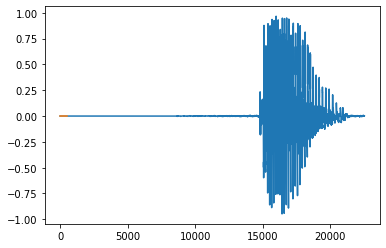

In [6]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

### 2. 데이터 설정 및 전처리
- speech MNIST 데이터 불러오기

In [11]:
# 오디오 데이터: 4명의 발화자(sb, yi, jy, sw). 발화자 당 500개의 오디오 파일. 총 2000개
DATA_DIR = 'data/recordings/'

- 데이터 설정

In [7]:
# sb라는 발화자의 데이터만 테스트데이터로, 나머지는 학습데이터로 설정.
test_speaker = 'sb'
X_train = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
y_train = []

X_test = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
y_test = []

In [8]:
import numpy as np
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
# 패딩함수 생성

# 1차원 패딩함수 생성
def pad1d(a, i):   # a는 wave, i는 데이터수
  if a.shape[0] > i:
    return a[0:i]   # wave의 데이터가 i보다 많은 경우, 모든 데이터를 출력
  else:
    return np.hstack((a, np.zeros(i - a.shape[0])))   # wave 데이터가 i보다 적거나 같은 경우, 개수 차이만큼의 0으로 채운 array를 수평으로 wave 데이터의 array 요소값에 추가

# 2차원 패딩함수 생성
def pad2d(a, i):
  if a.shape[1] > i:
    return a[:, 0:i] # wave의 데이터가 i보다 많은 경우, 모든 데이터를 출력
  else:
    return np.hstack((a, np.zeros((a.shape[0], i - a.shape[1])))) # wave 데이터의 갯수의 요소에 개수 차이만큼의 0으로 채운 array를 wave 데이터의 요소값에 추가

In [10]:
import os

In [12]:
for fname in os.listdir(DATA_DIR):
  try:
    if '.wav' not in fname or 'dima' in fname:    # 예외 처리
      continue    # 예외가 발생해도 계속 반복문 진행
    struct = fname.split('_')    # 파일명을 문자 사이를 '_'으로 구분 인식 / ex) 0_sb.wav
    digit = struct[0]    # 파일명의 첫번째 문자열은 발화 숫자 (0~9)
    speaker = struct[1]    # 파일명의 두번째 문자열은 발화자 (sb, yi, jy, sw)
    wav, sr = librosa.load(DATA_DIR + fname)
    X_padded = pad1d(wav, 30000)    # wave의 1차원 데이터를 패딩하여 데이터 값을 늘림.
    spectrogram = np.abs(librosa.stft(wav))   # STFT (Short Time Fourier Transform): 음성을 작은 조각으로 자르고 푸리에 변환을 적용해 시간(0.01초)에 따른 진동수 분포를 파악
    spectrogram_padded = pad2d(spectrogram, 40)    # spectrogram: STFT 결과를 L2 정규화(절대값)한 결과 / spectrogram 데이터를 패딩하여 2차원 데이터 값을 늘림.

    mel_spectrogram = librosa.feature.melspectrogram(wav)   # melspectrogram: spectrogram에 고음(민감) / 저음(둔감) 특징을 반영한 mel-filter를 적용하여 데이터 축소.
    mel_spectrogram_padded = pad2d(mel_spectrogram, 40) 

    mfcc = librosa.feature.mfcc(wav)   # MFCC (Mel-Frequency Cepstral Coefficients): 입력 신호에서 음성을 작은 조각으로 자르고 노이즈 및 배경 소리를 제거하여 유효한 소리만 추출
    mfcc_padded = pad2d(mfcc, 40)

    if speaker == test_speaker:   # 발화자 sb의 데이터는 테스트데이터
      X_test.append(X_padded)    # 발화자 sb의 음성 파일에서 추출한 wave 데이터를 패딩하여 모두 결합
      test_spectrograms.append(spectrogram_padded)
      test_mel_spectrograms.append(mel_spectrogram_padded)
      test_mfccs.append(mfcc_padded)
      y_test.append(digit)   # 발화 숫자는 y 
    else:
      X_train.append(X_padded)   # 발화자 yi, jy, sw의 데이터는 학습데이터
      train_spectrograms.append(spectrogram_padded)
      train_mel_spectrograms.append(mel_spectrogram_padded)
      train_mfccs.append(mfcc_padded)
      y_train.append(digit)
  except Exception as e: 
    print(fname, e) # 상위 try 이하 명령 실행 도중 예외(Exception 오류)가 발생 시 실행을 멈추지 않고 이후 해당 음성 파일 이름을 출력
    raise # 예외 (파일명에 '.wave'가 없거나 'dima'를 포함하거나) 처리

FileNotFoundError: ignored

- 데이터 전처리

In [13]:
from tensorflow.keras.utils import to_categorical

In [14]:
X_train = np.vstack(X_train) # 모든 학습데이터를 수직으로 array를 결합
train_spectrograms = np.array(train_spectrograms)  # 리스트를 array로 변환
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
y_train = to_categorical(np.array(y_train))   # 발화 숫자를 One-hot encoding 하여 전처리

X_test = np.vstack(X_test)
test_spectrograms = np.array(test_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
test_mfccs = np.array(test_mfccs)
y_test = to_categorical(np.array(y_test))

ValueError: ignored

In [15]:
print('X_train:', X_train.shape)
print('train_spectrogram:', train_spectrograms.shape)
print('train_mel_spectrogram:', train_mel_spectrograms.shape)
print('train_mfccs:', train_mfccs.shape)
print('y_train:', y_train.shape)

print('X_test:', X_test.shape)
print('test_spectrogram:', test_spectrograms.shape)
print('test_mel_spectrogram:', test_mel_spectrograms.shape)
print('test_mfccs:', test_mfccs.shape)
print('y_test:', y_test.shape)

AttributeError: ignored

### 3. 모델 학습
- Simple MLP with raw waves

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# 모델 정의
model = Sequential([                 
    Dense(128, input_shape=(X_train[0].shape), activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

In [ ]:
# 모델 설정
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

In [ ]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10, batch_size=32,
    validation_data=(X_test, y_test)
)

In [ ]:
# 훈련과정 시각화
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], 'bo-', markersize=2, label='Train Accuracy')
plt.plot(history.history['val_acc'], 'ro-', markersize=2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- CNN with MFCC (Mel-Frequency Cepstral Coefficients)

In [ ]:
X_train_ex = np.expand_dims(train_mfccs, -1)   # 차원 추가 (.reshape()와 동일)
X_test_ex = np.expand_dims(test_mfccs, -1)
print('X train shape:', X_train_ex.shape)
print('X test shape:', X_test_ex.shape)

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

In [ ]:
# 모델 정의
model = Sequential([
    Conv2D(64, (4,4), input_shape=X_train_ex[0].shape, activation='relu'),  # Convolution 층 추가
    MaxPooling2D((pool_size=4),    # Convolution 결과를 MaxPooling으로 축소
    Flatten(),             # n차원을 1차원(기본층)으로 변환
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

In [ ]:
# 모델 설정
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

In [ ]:
# 모델 학습
history = model.fit(
    X_train_ex, y_train_ex,
    epochs=100, batch_size=32, verbose=1,
    validation_data=(X_test_ex, y_test_ex)
)

In [ ]:
# 훈련과정 시각화
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], 'bo-', markersize=2, label='Train Accuracy')
plt.plot(history.history['val_acc'], 'ro-', markersize=2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()